# Applied Data Science Capstone Coursera

## The Battle of Neighbourhoods Notebook

## Exploring venues in Bhopal, India using FourSqaure and Zomato APIs

### Introduction

Through this Coursera Capstone project we shall explore venues(mostly restaurants, cafes and other eating joints) in the city of **Bhopal, India**. For this project we shall make use of **FourSquare** and **Zomato APIs**. This will then help the visitors to this city in selecting the venues that fit their budgets.

The **target audience** for this project will be visitors/tourists as well as any company that can launch an application using the data collected by us and provide users with further information.

The project will make use of Data Science concepts learned during the Coursera courses as well APIs mentioned above.

### Data Gathering

We shall first get the latitude and longitude of the city of Bhopal using the geopy library in python.
Next we shall make use of the two APIs namely:
**FourSqauare API** - through this API we shall fetch venues in the city of Bhopal starting from the geographical coordinates provided by geopy for the city upto a distance of 10 kilometres.
**Zomato API** - this will provide us further information about the venues obtained using FourSquare API such as address, visitor ratings, price and many more fields.

First things first, let's import the libraries required for our project.

In [3]:
import pandas as pd
import numpy as np 

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    sci

### Bhopal

Using the geopy library we extract the latitude and longitude values of Bhopal, India.

In [4]:
# Get the geographical coordinates of Bhopal city in India
address = 'Bhopal, India'

geolocator = Nominatim(user_agent="bpl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bhopal are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bhopal are 23.2530923, 77.3962718.


Now that we have the coordinates let's visualize the city of Bhopal through a folium map. Using a marker we shall point out the spot in the city which represents the coordinates obtained above.

In [5]:
# Create a map of Bhopal city with city centre marked
bhopal_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.Marker([latitude, longitude]).add_to(bhopal_map)

bhopal_map

### FourSquare API

Making use of the FourSquare API we shall fetch all venues in Bhopal upto a range of 10 kilometres. We shall make use of the 'explore' keyword in the API which will return venues within a given radius from the given coordinates.

In [6]:
CLIENT_ID = 'IYYYZV2BGTOSZN0OPSHDV0XPS320LAH1PY2BYBBGI2GMWSOI' # your Foursquare ID
CLIENT_SECRET = 'ATDK5BUQ22DHQ31PW5WRZAER4QF3ZLJZWNEB23ZNHHA4EE3C' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYYYZV2BGTOSZN0OPSHDV0XPS320LAH1PY2BYBBGI2GMWSOI
CLIENT_SECRET:ATDK5BUQ22DHQ31PW5WRZAER4QF3ZLJZWNEB23ZNHHA4EE3C


We define a get_category_type function to extract the category from each venue

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We wil now make calls to the API to get all the venues we can within the given radius. The maximum venues the API can fetch at one time is 100 so we shall fetch venues by iteratively calling the API.
Following points are to be noted:
1. We will set the radius as 10 km
2. Client id, client secret, version, latitude, longitude will be used as defined in above cells

In [8]:
RADIUS = 10000 # 10 Km
NO_OF_VENUES = 100

offset = 0
total_venues = 0
bhopal_venues_fs = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        latitude, 
                                                                        longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    bhopal_venues_fs = pd.concat([bhopal_venues_fs, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

bhopal_venues_fs = bhopal_venues_fs.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 47 venues fetched within a total radius of 10.0 Km

Total 47 venues fetched


So a total of 47 venues were returned using the FourSquare API. Let us observe the data types of the dataframe bhopal_venues_fs

In [30]:
bhopal_venues_fs.dtypes

name           object
categories     object
lat           float64
lng           float64
dtype: object

We shall save the dataframe to a csv file.

In [10]:
bhopal_venues_fs.to_csv(r'bhopal_venues_fs.csv')

### Zomato API

Using the zomato API we shall search for given venues based on latitude and longitude, among others. The user key used by us in the following cell can be accessed through a developer account. It allows for 1000 calls/day which will suffice our requirements.

We will use the *name, lat, lng* values of venues fetched from the FourSquare API as above to search the zomato database for more informtion about the venues.
+ The query will be the name of the venue.
+ We will supply the latitude and longitude values.
+ We will set the sorting criteria as real_distance so that each time we get the venue we are searching based on location coordinates.

In [11]:
headers = {'user-key': '7ea81899b6bf1b68d08b23ee8f9d52d8'}
venues_information = []

for index, row in bhopal_venues_fs.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

Let us have a look at the venues_information list

In [12]:
venues_information

[['Raju Tea Stall',
  '23.2583343956',
  '77.3953107744',
  100,
  1,
  '4.4',
  'Ambedkar Library, Sultania Road, Fatehgarh, Peer Gate Area, Bhopal'],
 ['TAO - Jehan Numa Palace',
  '23.2415894765',
  '77.3869000375',
  2200,
  4,
  '4.5',
  'Hotel Jehan Numa Palace, 157, Shymala Hills, TT Nagar, Bhopal'],
 ['La Kuchina - Jehan Numa Palace',
  '23.2415894765',
  '77.3869000375',
  2200,
  4,
  '4.6',
  '157, Hotel Jehan Numa Palace, Shymala Hills, TT Nagar, Bhopal'],
 ['Manohar Dairy And Restaurant',
  '23.2642068487',
  '77.4084666744',
  300,
  1,
  '4.5',
  '6, Hamidia Road, Opposite Alpana Cineplex, Peer Gate Area, Bhopal'],
 ['CafeChino - Jehan Numa Palace',
  '23.2417641510',
  '77.3880634457',
  800,
  3,
  '4.6',
  'Hotel Jehan Numa Palace, 157, Shamla Hills, TT Nagar, Bhopal'],
 ['Coriander Leaf',
  '23.2183048496',
  '77.3717511466',
  1500,
  4,
  '3.8',
  'Jehan Numa Retreat, Dr. Sallem Ali Road, Near Van Vihar Bhopal'],
 ['Amer Bakery Hut (ABH)',
  '23.2170955004',
  '77.

Convert the list into a pandas dataframe for further processing and filtering, using appropriate column names as below.

In [14]:
bhopal_venues_zm = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Have a look at the pandas dataframe obtained from Zomato API calls

In [15]:
bhopal_venues_zm

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Raju Tea Stall,23.2583343956,77.3953107744,100.0,1.0,4.4,"Ambedkar Library, Sultania Road, Fatehgarh, Pe..."
1,TAO - Jehan Numa Palace,23.2415894765,77.3869000375,2200.0,4.0,4.5,"Hotel Jehan Numa Palace, 157, Shymala Hills, T..."
2,La Kuchina - Jehan Numa Palace,23.2415894765,77.3869000375,2200.0,4.0,4.6,"157, Hotel Jehan Numa Palace, Shymala Hills, T..."
3,Manohar Dairy And Restaurant,23.2642068487,77.4084666744,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee..."
4,CafeChino - Jehan Numa Palace,23.2417641510,77.3880634457,800.0,3.0,4.6,"Hotel Jehan Numa Palace, 157, Shamla Hills, TT..."
5,Coriander Leaf,23.2183048496,77.3717511466,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ..."
6,Amer Bakery Hut (ABH),23.2170955004,77.4275230989,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal"
7,Subway,23.2331598486,77.4297288805,500.0,2.0,3.7,"Third Floor, DB City Mall, Maharana Pratap Nag..."
8,Cafe Coffee Day,23.2418688940,77.3806853592,650.0,2.0,4.3,"Inside Boat Club, Behind Chief Minister's Bung..."
9,Milan Sweets And Namkeen,23.2328230000,77.4336100000,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal"


Check the data types of the columns in the zomato venues dataframe bhopal_venues_zm

In [31]:
bhopal_venues_zm.dtypes

venue             object
latitude          object
longitude         object
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object

Columns latitude and longitude have data type as object, so we shall change it to floating point integer so that further data analysis becomes easier.

In [32]:
bhopal_venues_zm[['latitude', 'longitude']] = bhopal_venues_zm[['latitude', 'longitude']].astype(float)

We shall save the dataframe to a csv file

In [33]:
bhopal_venues_zm.to_csv(r'bhopal_venues_zm.csv')

### Cleaning the Data

We shall check for the alignment of data obtained from the two API calls we have made.

First we shall plot the venues obtained on map.

Let's have a look at the FourSquare data on map.

In [18]:
bhopal_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

for name, lati, long in zip(bhopal_venues_fs['name'], bhopal_venues_fs['lat'], bhopal_venues_fs['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lati, long],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(bhopal_map)  

bhopal_map

From the map we can see that there are venues located nearby **Upper Lake** and **South-SouthEast** parts of the city.

Next we shall plot the Zomato data on the map.

In [34]:
bhopal_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

for venue, address, lati, long in zip(bhopal_venues_zm['venue'], bhopal_venues_zm['address'], 
                                               bhopal_venues_zm['latitude'], bhopal_venues_zm['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lati, long],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7).add_to(bhopal_map)  

bhopal_map

We can see that there are many venues overlapping in the two maps obtained above. However, there are other points also where the data does not match such as a green dot in Van Vihar National Park, venues nearby the Airport etc.

Now we shall combine the two dataframes by matching the corresponding latitude and longitude values of each venue. So I will round the latitude and longitude values to four decimal places and then calculate the difference between the corresponding latitude and longitude values. In case the difference is less than 0.0005, this would mean that the two locations are the same.

In [35]:
bhopal_venues_fs['lat'] = bhopal_venues_fs['lat'].apply(lambda lat: round(float(lat), 4))
bhopal_venues_fs['lng'] = bhopal_venues_fs['lng'].apply(lambda lng: round(float(lng), 4))
bhopal_venues_zm['latitude'] = bhopal_venues_zm['latitude'].apply(lambda lat: round(float(lat), 4))
bhopal_venues_zm['longitude'] = bhopal_venues_zm['longitude'].apply(lambda lng: round(float(lng), 4))

In [36]:
df = pd.concat([bhopal_venues_fs, bhopal_venues_zm], axis = 1)
df['lat_diff'] = df['latitude'] - df['lat']
df['lng_diff'] = df['longitude'] - df['lng']

In [46]:
filtered_venues = df[(abs(df['lat_diff']) <= 0.0005) & (abs(df['lng_diff']) <= 0.0005)].reset_index(drop = True)
filtered_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Manohar Dairy & Restaurant,Indian Restaurant,23.2642,77.4087,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee...",0.0000,-0.0002
1,Jehan Numa Retreat,Asian Restaurant,23.2181,77.3715,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ...",0.0002,0.0003
2,Amer Bakery Hut,Bakery,23.2171,77.4277,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal",0.0000,-0.0002
3,Courtyard Bhopal,Hotel,23.2332,77.4297,Subway,23.2332,77.4297,500.0,2.0,3.7,"Third Floor, DB City Mall, Maharana Pratap Nag...",0.0000,0.0000
4,Milan Restaurant,Asian Restaurant,23.2329,77.4336,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal",-0.0001,0.0000
5,D.B City Mall,Department Store,23.2332,77.4305,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ...",-0.0003,-0.0001
6,Top N Town Main Icecream Joint,Food Court,23.2353,77.4012,TOP N TOWN,23.2353,77.4012,200.0,1.0,4.4,"Shop 11, New Market, TT Nagar, Bhopal",0.0000,0.0000
7,10 Downing Street,Pub,23.2323,77.4302,10 Downing Street,23.2321,77.4303,1000.0,3.0,4.2,"Third Floor, DB City Mall, Maharana Pratap Nag...",-0.0002,0.0001
8,DB City Mall,Shopping Mall,23.2326,77.4301,Pizza Hut,23.2327,77.4301,600.0,2.0,3.9,"Third Floor, DB City Mall, Arera Hills, Mahara...",0.0001,0.0000
9,Bake n shake,Bakery,23.2333,77.4344,TOP N TOWN,23.2333,77.4344,200.0,1.0,3.6,"Shop 13, Jyoti Takies Complex, Maharana Pratap...",0.0000,0.0000


So we have now obatined a dataframe consisting of 26 venues in Bhopal. Taking a look at the names of venues obtained from the APIs, we find that some are a complete mismatch.

We drop rows numbered 3, 12, 18, 19, 20 from the above dataframe to get rid of inconsistencies in the dataframe.

In [47]:
filtered_venues.drop([3, 12, 18, 19, 20], inplace=True)

In [48]:
filtered_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Manohar Dairy & Restaurant,Indian Restaurant,23.2642,77.4087,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee...",0.0000,-0.0002
1,Jehan Numa Retreat,Asian Restaurant,23.2181,77.3715,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ...",0.0002,0.0003
2,Amer Bakery Hut,Bakery,23.2171,77.4277,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal",0.0000,-0.0002
4,Milan Restaurant,Asian Restaurant,23.2329,77.4336,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal",-0.0001,0.0000
5,D.B City Mall,Department Store,23.2332,77.4305,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ...",-0.0003,-0.0001
6,Top N Town Main Icecream Joint,Food Court,23.2353,77.4012,TOP N TOWN,23.2353,77.4012,200.0,1.0,4.4,"Shop 11, New Market, TT Nagar, Bhopal",0.0000,0.0000
7,10 Downing Street,Pub,23.2323,77.4302,10 Downing Street,23.2321,77.4303,1000.0,3.0,4.2,"Third Floor, DB City Mall, Maharana Pratap Nag...",-0.0002,0.0001
8,DB City Mall,Shopping Mall,23.2326,77.4301,Pizza Hut,23.2327,77.4301,600.0,2.0,3.9,"Third Floor, DB City Mall, Arera Hills, Mahara...",0.0001,0.0000
9,Bake n shake,Bakery,23.2333,77.4344,TOP N TOWN,23.2333,77.4344,200.0,1.0,3.6,"Shop 13, Jyoti Takies Complex, Maharana Pratap...",0.0000,0.0000
10,Sagart Gaire,Indian Restaurant,23.2231,77.4338,Sagar Gaire Fast Food : 7 Number,23.2233,77.4335,250.0,1.0,4.4,"Shop 101, B.D.A Complex, Habib Ganj, Bhopal",0.0002,-0.0003


The above as a much better dataframe for further data visualization and anlysis.

Now I will remove the unncesssary columns from the dataframe.

In [49]:
filtered_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff'], inplace=True)
filtered_venues

,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Indian Restaurant,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee..."
1,Asian Restaurant,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ..."
2,Bakery,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal"
4,Asian Restaurant,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal"
5,Department Store,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ..."
6,Food Court,TOP N TOWN,23.2353,77.4012,200.0,1.0,4.4,"Shop 11, New Market, TT Nagar, Bhopal"
7,Pub,10 Downing Street,23.2321,77.4303,1000.0,3.0,4.2,"Third Floor, DB City Mall, Maharana Pratap Nag..."
8,Shopping Mall,Pizza Hut,23.2327,77.4301,600.0,2.0,3.9,"Third Floor, DB City Mall, Arera Hills, Mahara..."
9,Bakery,TOP N TOWN,23.2333,77.4344,200.0,1.0,3.6,"Shop 13, Jyoti Takies Complex, Maharana Pratap..."
10,Indian Restaurant,Sagar Gaire Fast Food : 7 Number,23.2233,77.4335,250.0,1.0,4.4,"Shop 101, B.D.A Complex, Habib Ganj, Bhopal"


One odd thing we can notice in the above dataframe is the absence of index(row) numbers of the rows we have deleted(namely 3, 12, 18, 19, 20). So we shall reset the index values to get the remove this anomaly.

In [51]:
filtered_venues.reset_index(drop=True, inplace=True)
#print("Total venues available: {}".format(filtered_venues.shape[0]))
filtered_venues

,categories,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Indian Restaurant,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee..."
1,Asian Restaurant,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ..."
2,Bakery,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal"
3,Asian Restaurant,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal"
4,Department Store,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ..."
5,Food Court,TOP N TOWN,23.2353,77.4012,200.0,1.0,4.4,"Shop 11, New Market, TT Nagar, Bhopal"
6,Pub,10 Downing Street,23.2321,77.4303,1000.0,3.0,4.2,"Third Floor, DB City Mall, Maharana Pratap Nag..."
7,Shopping Mall,Pizza Hut,23.2327,77.4301,600.0,2.0,3.9,"Third Floor, DB City Mall, Arera Hills, Mahara..."
8,Bakery,TOP N TOWN,23.2333,77.4344,200.0,1.0,3.6,"Shop 13, Jyoti Takies Complex, Maharana Pratap..."
9,Indian Restaurant,Sagar Gaire Fast Food : 7 Number,23.2233,77.4335,250.0,1.0,4.4,"Shop 101, B.D.A Complex, Habib Ganj, Bhopal"


In [53]:
print("Total venues available: {}".format(filtered_venues.shape[0]))

Total venues available: 21


### Methodology and Analysis

Remember that we started the project with the objective of identifying the venues in Bhopal based on their ratings, cost etc.

So far we have obtained the requisite data and made necessary changes to it in order to suit our requirements.

Next, what we will do is **analyse this data** so obtained based on the venue ratings and price of each venue. We will look at **spots where many venues are located** so that any visitor can go to that spot and enjoy the benefit of choosing amongst the many options available. We will look at **venus that are highly as well as lowly rated** and plot a **map of high and low priced venues**.

Finally we will **cluster the venues using kmeans** clustering algorithm from scikit learn library.

In [55]:
import matplotlib.pyplot as plt

#### Categories

We have various types of venues in the final filtered_venues dataframe. We will plot a bar graph to take a look at the venue categories in the dataframe.

<BarContainer object of 14 artists>

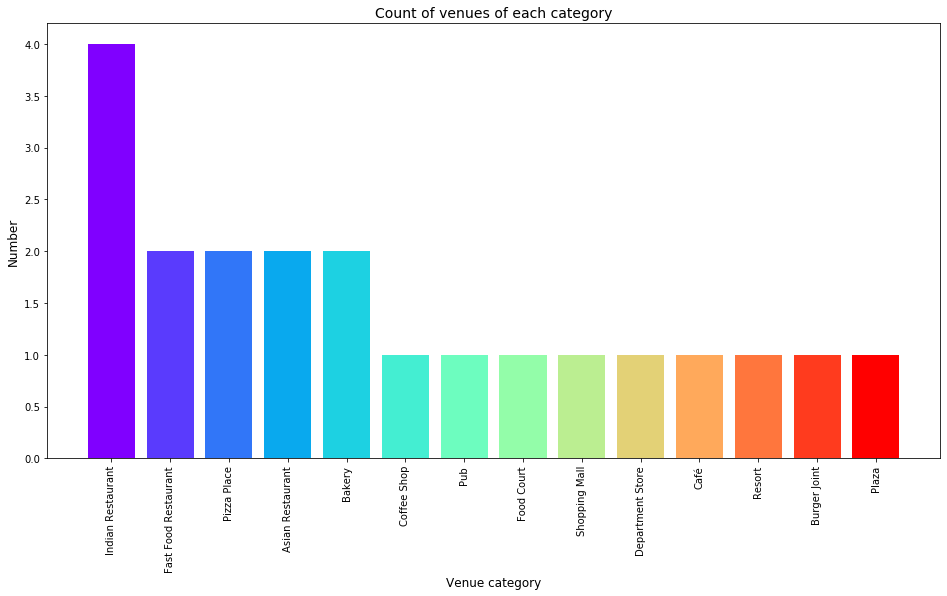

In [56]:
venue_distribution = filtered_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (16, 8))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 12)
plt.ylabel("Number", fontsize = 12)
plt.title("Count of venues of each category", fontsize = 14)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

From the above plot it is claer that the majority venues are **Indian Restaurant**, **Fast Food Restaurant**, **Pizza Place** and **Bakery**. So if a visitor is on the lookout for any of these he/she's in luck!

#### Rating

Visitors go to a venue only after having a look at the rating. To cater to such needs, we will plot the ratings on a bar graph first.

In [57]:
filtered_venues['rating'] = filtered_venues['rating'].astype(float)

Text(0.5, 1.0, 'Number of venues with given rating')

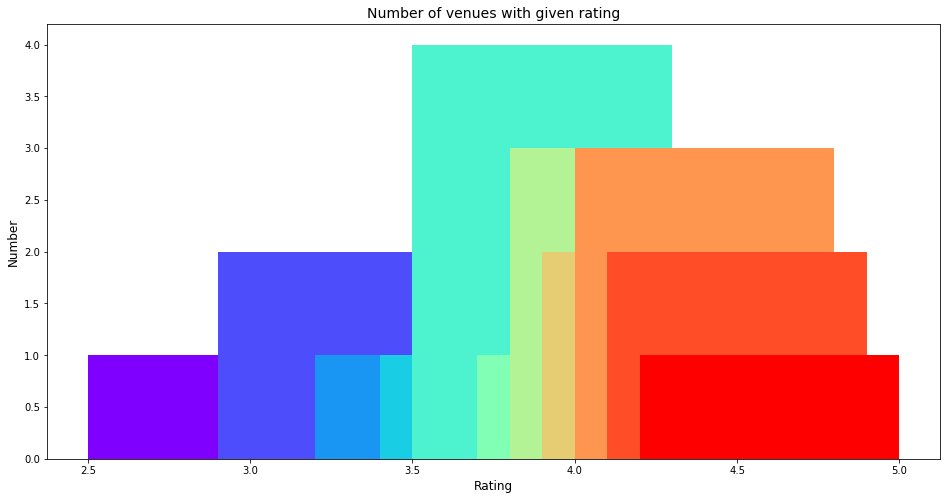

In [58]:
rating = filtered_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (16, 8))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 12)
plt.ylabel("Number", fontsize = 12)
plt.title("Number of venues with given rating", fontsize = 14)

From the abobe plot it is clear that the **majority of venues have rating close to 4**.

Lets us now create bins for various ratings and plot them on a folium map. The bins are as follows:
+ 2 to 3
+ 3 to 4
+ 4 to 5

In [59]:
bins = [2.0, 3.0, 4.0, 5.0]
labels = ['Okay', 'Good', 'Very good']
filtered_venues['rating_bin'] = pd.cut(filtered_venues['rating'], bins = bins, labels = labels, include_lowest = True)

Now we will plot the venues on a map

In [62]:
color_map = {'Okay': 'red', 'Good': 'orange', 'Very good': 'green'}

bhopal_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

for name, address, lati, long, rating_bin in zip(filtered_venues['venue'], 
                                                 filtered_venues['address'], 
                                                 filtered_venues['latitude'], 
                                                 filtered_venues['longitude'], 
                                                 filtered_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label)
    folium.Marker(
        [lati, long],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(bhopal_map)  

bhopal_map

From the map it appears that most of the venues in the centre of the city have good rating of above 4, while a few down south in the city and nearby the lake are moderatley rated(3 to 4).

#### Price

Let us now have a look at the venues using the price variable. We have two price features- price_for_two which defines the average cost for two people and price_range which determines the price range as defined by Zomato.

Let us have a look at the price_for_two using a scatter plot to see the number of venues. The size of the circles will be based on the price.

Text(0.5, 1.0, 'Number of venues with given price for two people')

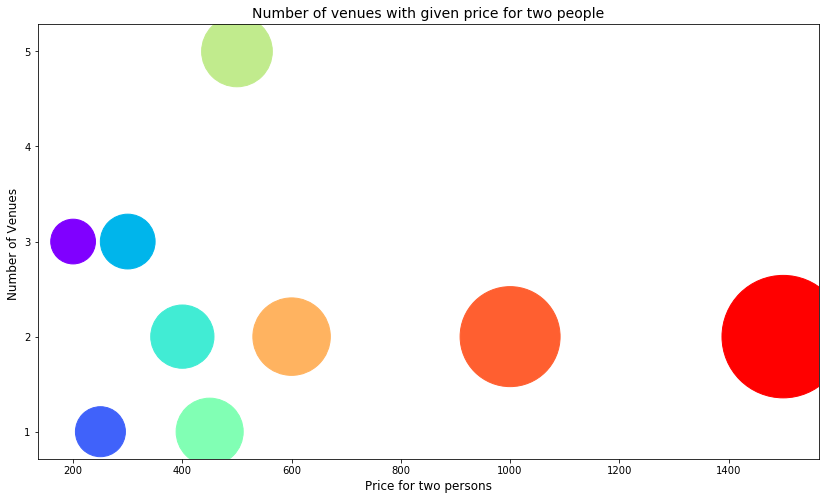

In [64]:
price_for_two = filtered_venues['price_for_two'].value_counts().sort_index()
plt.figure(figsize = (14, 8))
plt.scatter(price_for_two.index, 
            price_for_two.values, 
            s = price_for_two.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(price_for_two.index))))
plt.xlabel("Price for two persons", fontsize = 12)
plt.ylabel("Number of Venues ", fontsize = 12)
plt.title("Number of venues with given price for two people", fontsize = 14)

From the plot above we can see that most venues have a price of less than 600 Indian Rupees.

Next we shall plot the price_range cloumn to plot the venues on a map. The lower price range venues will be represented with greeen colour and higher price range venues with red.

In [65]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

for name, address, lati, long, price_range in zip(filtered_venues['venue'], 
                                                           filtered_venues['address'], 
                                                           filtered_venues['latitude'], 
                                                           filtered_venues['longitude'], 
                                                           filtered_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label)
    folium.Marker(
        [lati, long],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(bhopal_map)  

bhopal_map

Following observations can be made from the above map:
1. The venues lying just beside the lake are higher priced.
2. Venues in south, south-east part of the city have moderate prices.

#### Clustering

We will cluster the venues based on their price range, location etc to identify similar venues and the relationship amongst them. We will cluster the venues into two groups.

In [67]:
NO_OF_CLUSTERS = 2

clustering = filtered_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
filtered_venues.insert(0, 'cluster_labels', kMeans.labels_)
filtered_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,0,Indian Restaurant,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee...",Very good
1,1,Asian Restaurant,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ...",Good
2,0,Bakery,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal",Very good
3,0,Asian Restaurant,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal",Very good
4,0,Department Store,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ...",Good


Display the venue clusters on a map with cluster centre being the prominent markers.

In [68]:
bhopal_map = folium.Map(location = [latitude, longitude], zoom_start = 12)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, lati, long in zip(filtered_venues['venue'], 
                                               filtered_venues['address'], 
                                               filtered_venues['cluster_labels'], 
                                               filtered_venues['latitude'], 
                                               filtered_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address))
    folium.CircleMarker(
        [lati, long],
        radius = 4,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(bhopal_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    lat = cluster[0]
    lon = cluster[1]
    label = folium.Popup("Cluster: " + str(index))
    folium.CircleMarker(
        [lat, lon],
        radius = 8,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(bhopal_map)

bhopal_map

From the above map we can see the two clusters:
1. The first cluster is spread throughout the city(north, centre, south) and has majority of venues.
2. The second cluster is spread in areas just near the upper lake and has a limited number of venues.

#### Cluster Analysis

We will now check the venues in the two clusters.

In [69]:
result = filtered_venues[filtered_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,0,Indian Restaurant,Manohar Dairy And Restaurant,23.2642,77.4085,300.0,1.0,4.5,"6, Hamidia Road, Opposite Alpana Cineplex, Pee...",Very good
1,0,Bakery,Amer Bakery Hut (ABH),23.2171,77.4275,400.0,2.0,4.2,"Bittan Market, Arera Colony, Bhopal",Very good
2,0,Asian Restaurant,Milan Sweets And Namkeen,23.2328,77.4336,200.0,1.0,4.1,"Plot 189, Zone 1, Maharana Pratap Nagar, Bhopal",Very good
3,0,Department Store,Burger King,23.2329,77.4304,500.0,2.0,3.9,"11 & 12, Food Court, 3rd Floor, DB City Mall, ...",Good
4,0,Food Court,TOP N TOWN,23.2353,77.4012,200.0,1.0,4.4,"Shop 11, New Market, TT Nagar, Bhopal",Very good
5,0,Shopping Mall,Pizza Hut,23.2327,77.4301,600.0,2.0,3.9,"Third Floor, DB City Mall, Arera Hills, Mahara...",Good
6,0,Bakery,TOP N TOWN,23.2333,77.4344,200.0,1.0,3.6,"Shop 13, Jyoti Takies Complex, Maharana Pratap...",Good
7,0,Indian Restaurant,Sagar Gaire Fast Food : 7 Number,23.2233,77.4335,250.0,1.0,4.4,"Shop 101, B.D.A Complex, Habib Ganj, Bhopal",Very good
8,0,Coffee Shop,Bake N Shake,23.2146,77.4350,300.0,1.0,4.6,"B-1, GM Tower, Stop No. 10, Arera Colony, Bhopal",Very good
9,0,Indian Restaurant,Indian Coffee House,23.2349,77.4017,500.0,2.0,4.4,"Near Apex Bank, TT Nagar, Bhopal",Very good


In [70]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.59 and rating spread around 4.06


In [72]:
result = filtered_venues[filtered_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_for_two,price_range,rating,address,rating_bin
0,1,Asian Restaurant,Coriander Leaf,23.2183,77.3718,1500.0,4.0,3.8,"Jehan Numa Retreat, Dr. Sallem Ali Road, Near ...",Good
1,1,Pub,10 Downing Street,23.2321,77.4303,1000.0,3.0,4.2,"Third Floor, DB City Mall, Maharana Pratap Nag...",Very good
2,1,Resort,Marbal Arch - Noor Us Sabah Palace,23.2670,77.3685,1500.0,4.0,4.2,"Hotel Noor Us Sabah Palace, VIP Road, Kohefiza...",Very good
3,1,Indian Restaurant,Wind And Waves,23.2417,77.3805,1000.0,3.0,3.3,"Lake Driver Road, Van Vihar Road,\nShymla Hill...",Good


In [73]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.50 and rating spread around 3.88


### Results and Discussion

Based on the analysis made by us above, we can make the following conclusions that can aid any visitor arriving in the city of Bhopal, India.

After collecting data from FourSqaure and Zomato APIs, we got a list of 47 venues. However, not all the venues from the two APIs were identical. Therefore, we inspected the latitude and longitude values of all venues to combine similar venues and remove the outliers. The result we got was a dataframe consisting of 21 venues.

We identified from the total number of venues, majority of them were **Indian Restaurant**, **Fast Food Restaurant** and **Bakery**.

The ratings of the venues ranged from 2.5 to 5 but the **majority of them had a rating close to 4**. This means that most restaurants provide good quality food that is liked by most people in the city. On plotting these venues on a map, we saw that there are clusters of venues in and around the lake, down south which are moderatley rated(3 to 4) while veunes in the other cluster have a high rating(above 4).

On looking at the prices two people have to pay in these venues, we found out that **most of the venues offered prices of less than 600 Indian Rupees**. A map of price range of these venues showed that **venues nearby lake fall in higher price range** and other venues of the city fell in lower price ranges.

Finally through clusters we identified that there are **many venues** which are **relatively low on prices but have an average rating of 4.06**. On the other hand, there were a **handful of venues** which are **higher priced and have an avergae rating of 3.88**.

### Conclusion

The project looked at venues in the city of Bhopal, India. The venues were identified using the FourSquare and Zomato APIs. Maps were used to plot the venues. The map reveals that there are two major areas one can visit- nearby upper lake and rest of the city. Based on the visitor's choice of venue rating and budget availability, he/she can choose accordingly.